In [1]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import false_discovery_control, wilcoxon
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [2]:
results_dir = Path("./results")
data_dir = Path("./data")

dlpfc_data = data_dir / "LIBD_DLPFC"
dlpfc_results = results_dir / "LIBD_DLPFC"

sdmbench_data = data_dir / "sdmbench"
sdmbench_results = results_dir / "sdmbench"

runtime_results = results_dir / "runtime_memory.tsv"

fig_dir = results_dir / "figures"

metadata_file = "downloads.tsv"

In [3]:
fig_dir.mkdir(parents=True, exist_ok=True)

In [4]:
import matplotlib as mpl

mpl.rcParams.update(
    {
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "legend.fontsize": 5,
    }
)

In [5]:
mm = 0.1 / 2.54

dpi = 600

In [6]:
rename_methods = {
    "leiden": "Leiden HVG PCA",
    "spatial_leiden": "SpatialLeiden HVG PCA",
    "leiden_svg": "Leiden SVG PCA",
    "spatial_leiden_svg": "SpatialLeiden SVG PCA",
    "leiden_svg_multispati": "Leiden SVG msPCA",
    "spatial_leiden_svg_multispati": "SpatialLeiden SVG msPCA",
}

# DLPFC

In [7]:
groundtruth = pd.DataFrame(
    [(f.parent.name, f) for f in dlpfc_data.glob("*/labels.tsv")],
    columns=["sample", "groundtruth"],
).set_index("sample")

results = {
    f.name: {tsv.stem: tsv for tsv in f.glob("*.tsv")}
    for f in dlpfc_results.glob("Br*")
}

label_files = (
    pd.DataFrame(results)
    .transpose()
    .merge(groundtruth, left_index=True, right_index=True)
    .rename(columns=rename_methods)
)

## Fig1b Br8100-151673

In [8]:
sample = "Br8100_151673"

px_per_um = 96.40082438014726 / 65

In [9]:
coordinate_file = dlpfc_data / sample / "coordinates.tsv"
image_file = dlpfc_data / sample / "H_E.tiff"

In [10]:
from scipy.optimize import linear_sum_assignment

data = pd.read_table(coordinate_file, index_col=0)

files = label_files.loc[sample, :].copy()
labels_df = pd.read_table(files.pop("groundtruth"), index_col=0).astype("category")
labels_df.columns = ["groundtruth"]
labels_df["groundtruth"] = labels_df["groundtruth"].cat.rename_categories(
    {n: i for i, n in enumerate(labels_df.groundtruth.cat.categories)}
)

data = data.merge(labels_df, left_index=True, right_index=True)

for name, file in files.items():
    labels_df = pd.read_table(file, index_col=0).astype("category")
    labels_df.columns = [name]

    # match clusters
    contingency_table = pd.crosstab(labels_df[name], data["groundtruth"])
    row_ind, col_ind = linear_sum_assignment(contingency_table, maximize=True)
    labels_df[name] = labels_df[name].cat.rename_categories(
        dict(zip(contingency_table.index[row_ind], contingency_table.columns[col_ind]))
    )

    data = data.merge(labels_df, left_index=True, right_index=True)

In [11]:
from PIL import Image

# disable DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

image = np.array(Image.open(image_file))

x_crop = (data["x"].min(), data["x"].max())
y_crop = (data["y"].min(), data["y"].max())

image = image[slice(*y_crop), slice(*x_crop)]
data = data.assign(x=lambda df: df["x"] - x_crop[0], y=lambda df: df["y"] - y_crop[0])

In [12]:
scatter_kwargs = {
    "s": 3,
    "marker": "h",
    "linewidth": 0,
    "hue_order": data["groundtruth"].cat.categories,
}

In [13]:
def remove_tick_and_label(ax):
    ax.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None)
    ax.tick_params(left=False, bottom=False)


def scatter_labels(df, name, ax):
    _ = sns.scatterplot(df, x="x", y="y", hue=name, ax=ax, **scatter_kwargs)
    ax.set(title=name, aspect=1, xlim=(0, df["x"].max()), ylim=(df["y"].max(), 0))
    ax.legend([], [], frameon=False)
    remove_tick_and_label(ax)

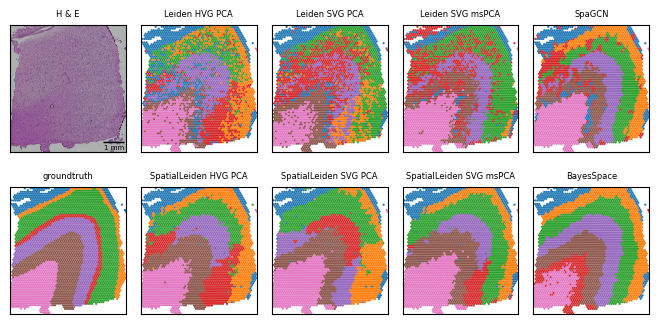

In [14]:
fig1b, axs = plt.subplots(
    nrows=2, ncols=5, sharex=True, sharey=True, figsize=(170 * mm, 85 * mm)
)
_ = axs[0, 0].imshow(image)
axs[0, 0].set(title="H & E")
remove_tick_and_label(axs[0, 0])
scale_bar = AnchoredSizeBar(
    axs[0, 0].transData,
    px_per_um * 1_000,
    r"1 mm",
    loc="lower right",
    frameon=False,
    fontproperties={"size": 5},
)
axs[0, 0].add_artist(scale_bar)

scatter_labels(data, "groundtruth", axs[1, 0])
scatter_labels(data, "Leiden HVG PCA", axs[0, 1])
scatter_labels(data, "SpatialLeiden HVG PCA", axs[1, 1])
scatter_labels(data, "Leiden SVG PCA", axs[0, 2])
scatter_labels(data, "SpatialLeiden SVG PCA", axs[1, 2])
scatter_labels(data, "Leiden SVG msPCA", axs[0, 3])
scatter_labels(data, "SpatialLeiden SVG msPCA", axs[1, 3])
scatter_labels(data, "SpaGCN", axs[0, 4])
scatter_labels(data, "BayesSpace", axs[1, 4])

fig1b.tight_layout(h_pad=2)
# fig1b.savefig(fig_dir / "Fig1b.pdf", dpi=dpi)
fig1b.savefig(fig_dir / "Fig1b.png", dpi=dpi)

## Fig1c ARI & NMI

In [15]:
def calculate_score(fn, groundtruth, cluster, **kwargs):
    domains = pd.read_table(cluster, index_col=0)["label"].astype("category").cat.codes
    groundtruth = (
        pd.read_table(groundtruth, index_col=0)["label"].astype("category").cat.codes
    )
    common_index = domains.index.intersection(groundtruth.index)
    return fn(groundtruth.loc[common_index], domains.loc[common_index], **kwargs)


def get_ncluster(file):
    return pd.read_table(file)["label"].astype("category").cat.categories.size

In [16]:
methods = label_files.columns.to_series().loc[lambda s: s != "groundtruth"].tolist()
scores = label_files.melt(
    id_vars="groundtruth",
    value_vars=methods,
    var_name="Method",
    value_name="filepath",
    ignore_index=False,
).assign(
    ARI=lambda df: df.apply(
        lambda row: calculate_score(adjusted_rand_score, row.groundtruth, row.filepath),
        axis=1,
    ),
    NMI=lambda df: df.apply(
        lambda row: calculate_score(
            normalized_mutual_info_score, row.groundtruth, row.filepath
        ),
        axis=1,
    ),
)

In [17]:
order = [
    "Leiden HVG PCA",
    "Leiden SVG PCA",
    "Leiden SVG msPCA",
    "SpatialLeiden HVG PCA",
    "SpatialLeiden SVG PCA",
    "SpatialLeiden SVG msPCA",
    "SpaGCN",
    "BayesSpace",
]

In [18]:
# check number of clusters
label_files.map(get_ncluster).sort_index()[["groundtruth"] + order]

,groundtruth,Leiden HVG PCA,Leiden SVG PCA,Leiden SVG msPCA,SpatialLeiden HVG PCA,SpatialLeiden SVG PCA,SpatialLeiden SVG msPCA,SpaGCN,BayesSpace
Br5292_151507,7,7,7,7,7,8,7,7,7
Br5292_151508,7,7,7,7,7,7,7,7,7
Br5292_151509,7,7,7,7,7,7,7,7,7
Br5292_151510,7,7,7,7,7,7,7,7,7
Br5595_151669,5,5,5,5,5,5,5,5,5
Br5595_151670,5,5,5,5,5,5,5,4,5
Br5595_151671,5,5,5,5,5,5,5,5,5
Br5595_151672,5,5,5,5,5,5,5,5,5
Br8100_151673,7,7,7,7,7,7,7,7,7
Br8100_151674,7,7,7,7,7,7,7,6,7


In [19]:
ari_dlpfc = scores.pivot(columns="Method", values="ARI")
nmi_dlpfc = scores.pivot(columns="Method", values="NMI")

ari_dlpfc.to_csv(fig_dir / "ARI.tsv", sep="\t")
nmi_dlpfc.to_csv(fig_dir / "NMI.tsv", sep="\t")

In [20]:
ari_dlpfc.median().sort_values(ascending=False)

Method
BayesSpace                 0.452809
SpatialLeiden HVG PCA      0.450992
SpatialLeiden SVG PCA      0.440181
SpatialLeiden SVG msPCA    0.434641
SpaGCN                     0.434261
Leiden SVG msPCA           0.361995
Leiden SVG PCA             0.348672
Leiden HVG PCA             0.322712
dtype: float64

In [21]:
nmi_dlpfc.median().sort_values(ascending=False)

Method
BayesSpace                 0.600139
SpatialLeiden SVG PCA      0.572301
SpatialLeiden SVG msPCA    0.569592
SpatialLeiden HVG PCA      0.569182
SpaGCN                     0.543325
Leiden SVG msPCA           0.476132
Leiden SVG PCA             0.451019
Leiden HVG PCA             0.428957
dtype: float64

In [22]:
# best performing method per sample
ari_dlpfc.idxmax(axis=1)

Br5292_151507      SpatialLeiden SVG PCA
Br5292_151508                 BayesSpace
Br5292_151509                 BayesSpace
Br5292_151510      SpatialLeiden HVG PCA
Br5595_151669                 BayesSpace
Br5595_151670                 BayesSpace
Br5595_151671                 BayesSpace
Br5595_151672    SpatialLeiden SVG msPCA
Br8100_151673                 BayesSpace
Br8100_151674      SpatialLeiden HVG PCA
Br8100_151675                 BayesSpace
Br8100_151676                     SpaGCN
dtype: object

In [23]:
flierprops = dict(marker=".", markerfacecolor="black", markersize=2)

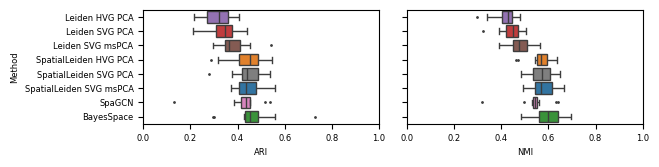

In [24]:
fig1c, axs = plt.subplots(
    ncols=2, figsize=(170 * mm, 45 * mm), sharex=True, sharey=True
)
sns.boxplot(
    data=scores,
    y="Method",
    x="ARI",
    hue="Method",
    order=order,
    flierprops=flierprops,
    ax=axs[0],
)
_ = axs[0].set(xlim=(0, 1))

sns.boxplot(
    data=scores,
    y="Method",
    x="NMI",
    hue="Method",
    order=order,
    flierprops=flierprops,
    ax=axs[1],
)

fig1c.tight_layout()
fig1c.savefig(fig_dir / "Fig1c.pdf", dpi=dpi)
fig1c.savefig(fig_dir / "Fig1c.png", dpi=dpi)

### Testing

In [25]:
from itertools import product


def pairwise_wilcoxon(df: pd.DataFrame, **kwargs):
    p_values = pd.DataFrame(np.nan, columns=df.columns, index=df.columns)
    columns = df.columns.tolist()
    for c in df.columns:
        for c2 in df.columns:
            if c != c2:
                p_values.at[c2, c] = wilcoxon(df[c], df[c2], **kwargs).pvalue
    return p_values


# BH correction
def adjust_p_value(p_df: pd.DataFrame):
    p_adjusted = p_df.to_numpy()
    p_adjusted[np.triu_indices(p_adjusted.shape[0])] = np.nan
    p_adjusted = (
        pd.DataFrame(p_adjusted, columns=p_df.columns, index=p_df.index)
        .melt(ignore_index=False, var_name="vs", value_name="p_value")
        .reset_index()
        .dropna()
    )
    p_adjusted["p_value"] = false_discovery_control(p_adjusted["p_value"].to_numpy())

    all_combinations = pd.DataFrame(
        list(product(p_df.columns, p_df.index)), columns=["Method", "vs"]
    )

    p_adjusted = pd.merge(
        all_combinations, p_adjusted, on=["Method", "vs"], how="outer"
    ).pivot(index="Method", columns="vs", values="p_value")
    p_adjusted = pd.DataFrame(
        np.tril(p_adjusted) + np.tril(p_adjusted).T,
        index=p_adjusted.index,
        columns=p_adjusted.columns,
    )
    return p_adjusted

#### ARI

In [26]:
p_values = pairwise_wilcoxon(ari_dlpfc)
p_adjusted = adjust_p_value(p_values)
p_adjusted.to_csv(fig_dir / "ARI_pvalues.tsv", sep="\t", float_format="{:.2g}".format)
p_adjusted

vs,BayesSpace,Leiden HVG PCA,Leiden SVG PCA,Leiden SVG msPCA,SpaGCN,SpatialLeiden HVG PCA,SpatialLeiden SVG PCA,SpatialLeiden SVG msPCA
Method,,,,,,,,
BayesSpace,NaN,0.005859,0.008545,0.013672,0.316732,0.526094,0.590422,0.558444
Leiden HVG PCA,0.005859,NaN,0.372559,0.004557,0.013672,0.003418,0.003418,0.003418
Leiden SVG PCA,0.008545,0.372559,NaN,0.022786,0.013672,0.009570,0.009570,0.003418
Leiden SVG msPCA,0.013672,0.004557,0.022786,NaN,0.086052,0.036743,0.012429,0.004557
SpaGCN,0.316732,0.013672,0.013672,0.086052,NaN,0.526094,0.372559,0.401693
SpatialLeiden HVG PCA,0.526094,0.003418,0.009570,0.036743,0.526094,NaN,0.733398,0.431907
SpatialLeiden SVG PCA,0.590422,0.003418,0.009570,0.012429,0.372559,0.733398,NaN,0.515965
SpatialLeiden SVG msPCA,0.558444,0.003418,0.003418,0.004557,0.401693,0.431907,0.515965,NaN


#### NMI

In [27]:
p_values = pairwise_wilcoxon(nmi_dlpfc)
p_adjusted = adjust_p_value(p_values)
p_adjusted.to_csv(fig_dir / "NMI_pvalues.tsv", sep="\t", float_format="{:.2g}".format)
p_adjusted

vs,BayesSpace,Leiden HVG PCA,Leiden SVG PCA,Leiden SVG msPCA,SpaGCN,SpatialLeiden HVG PCA,SpatialLeiden SVG PCA,SpatialLeiden SVG msPCA
Method,,,,,,,,
BayesSpace,NaN,0.001139,0.001139,0.001139,0.041775,0.112347,0.163011,0.312428
Leiden HVG PCA,0.001139,NaN,0.056641,0.001709,0.001709,0.001139,0.001139,0.001139
Leiden SVG PCA,0.001139,0.056641,NaN,0.001709,0.001709,0.001139,0.001139,0.001139
Leiden SVG msPCA,0.001139,0.001709,0.001709,NaN,0.026540,0.001139,0.001139,0.001139
SpaGCN,0.041775,0.001709,0.001709,0.026540,NaN,0.163011,0.150960,0.056641
SpatialLeiden HVG PCA,0.112347,0.001139,0.001139,0.001139,0.163011,NaN,0.518555,0.112347
SpatialLeiden SVG PCA,0.163011,0.001139,0.001139,0.001139,0.150960,0.518555,NaN,0.056641
SpatialLeiden SVG msPCA,0.312428,0.001139,0.001139,0.001139,0.056641,0.112347,0.056641,NaN


# SDMbench comparison

In [28]:
def calculate_NMI_sdmbench(h5ad_path, label_path, **kwargs):
    domains_df = pd.read_table(label_path, index_col=0)
    # adata obs_names is always str
    domains_df.index = domains_df.index.astype(str)
    domains = domains_df["label"].astype("category").cat.codes

    groundtruth = (
        ad.read_h5ad(h5ad_path).obs["ground_truth"].astype("category").cat.codes
    )
    common_index = domains.index.intersection(groundtruth.index)

    return normalized_mutual_info_score(
        groundtruth.loc[common_index], domains.loc[common_index], **kwargs
    )

In [29]:
metadata = pd.read_table(metadata_file, index_col=0)

metadata = metadata.assign(
    path=lambda df: sdmbench_data / df["url"].str.split("/").str[-1]
)

In [30]:
sdmbench_metrics = (
    pd.read_excel(data_dir / "sdmbench_metrics.xlsx")
    .iloc[:, 3:]
    .loc[lambda df: df["DataName"].isin(metadata.index.tolist())]
    .loc[lambda df: df["Method"] != "louvain"]
)

sample2technology = (
    sdmbench_metrics.loc[:, ["DataName", "Biotech"]]
    .drop_duplicates()
    .set_index("DataName")
    .to_dict()["Biotech"]
)

In [31]:
metadata = pd.merge(
    metadata,
    pd.DataFrame(sdmbench_results.glob("*.tsv"), columns=["label_path"]).assign(
        info=lambda df: df["label_path"].map(lambda p: p.stem),
        sample=lambda df: df["info"].str.extract("(.+)_seed"),
        seed=lambda df: df["info"].str.extract("_seed(\d+)"),
        neighbors=lambda df: df["info"]
        .str.extract("_neighbors-([^_]+)")
        .replace({"10": "kNN-10", "delaunay": "Delaunay", "grid4": "square"}),
        features=lambda df: df["info"].str.extract("FS-([^_]+)"),
        dimred=lambda df: df["info"].str.extract("_DR-([^_]+)"),
    ),
    left_index=True,
    right_on="sample",
).set_index(["sample", "seed", "neighbors", "features", "dimred"])

In [32]:
nmi_spatialleiden = (
    metadata.apply(lambda row: calculate_NMI_sdmbench(row.path, row.label_path), axis=1)
    .to_frame("NMI")
    .reset_index()
    .assign(
        Method="SpatialLeiden",
        Biotech=lambda df: df["sample"].map(lambda x: sample2technology[x]),
    )
)

In [33]:
cols = ["Biotech", "sample", "neighbors", "features", "dimred", "seed", "NMI"]

nmi_spatialleiden.loc[:, cols].sort_values(cols[:-1]).to_csv(
    fig_dir / "NMI_sdmbench_datasets.tsv", sep="\t", index=False
)

In [34]:
nmi_spatialleiden = (
    nmi_spatialleiden.fillna({"features": ""})
    .groupby(["sample", "Biotech", "neighbors", "features", "dimred", "Method"])
    .agg({"NMI": "median"})
    .reset_index()
    .rename(columns={"sample": "DataName"})
)

In [35]:
nmi = pd.concat(
    [
        nmi_spatialleiden,
        sdmbench_metrics.loc[:, ["DataName", "Replicate", "Biotech", "Method", "NMI"]]
        .groupby(["DataName", "Method", "Biotech"])
        .agg({"NMI": "median"})
        .reset_index(),
    ]
)

## Fig2

In [36]:
def nmi_plot(nmi_df, technology, ax, cmap):
    nmi_df = nmi_df.loc[lambda df: df["Biotech"] == technology]

    n_sample = nmi_df["DataName"].nunique()

    order = nmi_df.groupby("Method").agg({"NMI": "median"}).sort_values("NMI").index

    plotting_fn = sns.barplot if nmi_df["DataName"].unique().size == 1 else sns.boxplot

    kwargs = {"palette": cmap}
    if plotting_fn == sns.boxplot:
        kwargs["flierprops"] = flierprops

    _ = plotting_fn(
        data=nmi_df, y="Method", x="NMI", hue="Method", order=order, ax=ax, **kwargs
    )
    ax.set(xlim=(0, 1), title=f"{technology} (n = {n_sample})")

In [37]:
is_spatialleiden = nmi["Method"] == "SpatialLeiden"

nmi.loc[is_spatialleiden, "Method"] = nmi.loc[is_spatialleiden].assign(
    method=lambda df: df["Method"]
    + " ("
    + np.where(df["features"] == "", "", df["features"] + " ")
    + df["dimred"]
    + " "
    + df["neighbors"]
    + ")"
)["method"]

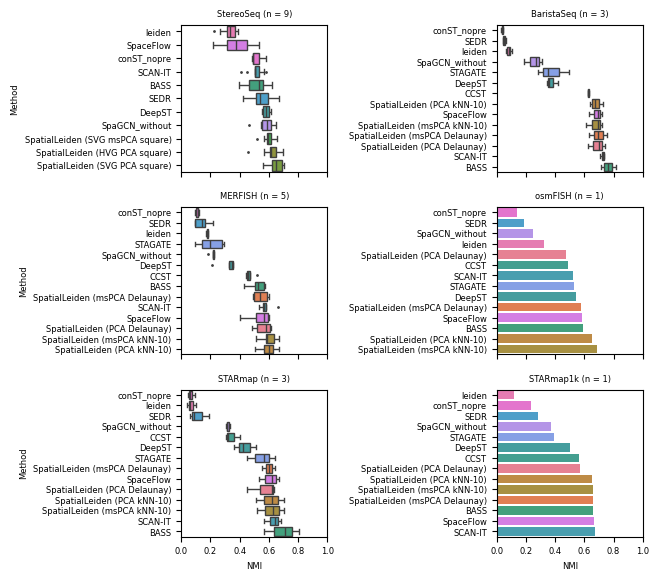

In [38]:
fig2, axs = plt.subplots(nrows=3, ncols=2, figsize=(170 * mm, 150 * mm), sharex=True)

methods = nmi.Method.unique()
cmap = {m: c for m, c in zip(methods, sns.color_palette("husl", len(methods)))}

nmi_plot(nmi, "StereoSeq", axs[0, 0], cmap)
nmi_plot(nmi, "BaristaSeq", axs[0, 1], cmap)
nmi_plot(nmi, "MERFISH", axs[1, 0], cmap)
nmi_plot(nmi, "osmFISH", axs[1, 1], cmap)
nmi_plot(nmi, "STARmap", axs[2, 0], cmap)
nmi_plot(nmi, "STARmap1k", axs[2, 1], cmap)

axs[0, 1].set(ylabel=None)
axs[1, 1].set(ylabel=None)
axs[2, 1].set(ylabel=None)

fig2.tight_layout()
fig2.savefig(fig_dir / "Fig2.pdf", dpi=dpi)
fig2.savefig(fig_dir / "Fig2.png", dpi=dpi)

### Testing

In [39]:
ref = "SpatialLeiden (HVG PCA square)"

In [40]:
def pairwise_wilcoxon(df: pd.DataFrame, ref: str, **kwargs):
    methods = [c for c in df.columns if c != ref]
    p_values = pd.DataFrame(0.0, columns=[ref], index=methods)
    for c in methods:
        if c != ref:
            p_values.at[c, ref] = wilcoxon(df[c], df[ref], **kwargs).pvalue
    return p_values

In [41]:
stereoseq_nmi = nmi.loc[lambda df: df["Biotech"] == "StereoSeq"].pivot(
    index="DataName", columns="Method", values="NMI"
)

In [42]:
p_values = pairwise_wilcoxon(stereoseq_nmi, ref, nan_policy="omit")

p_values = p_values.melt(var_name="vs", value_name="p_value", ignore_index=False)

# number of samples
p_values["n"] = 0
for i in p_values.index:
    if i != ref:
        p_values.at[i, "n"] = stereoseq_nmi[[i, ref]].dropna().shape[0]

# BH correction
p_values["p_BHadjusted"] = false_discovery_control(p_values["p_value"])

p_values.to_csv(fig_dir / "StereoSeq_wilcoxon.tsv", sep="\t", float_format="%.3g")

p_values.sort_values("p_BHadjusted")

,vs,p_value,n,p_BHadjusted
BASS,SpatialLeiden (HVG PCA square),0.007812,8,0.013021
SCAN-IT,SpatialLeiden (HVG PCA square),0.003906,9,0.013021
SEDR,SpatialLeiden (HVG PCA square),0.007812,8,0.013021
SpaceFlow,SpatialLeiden (HVG PCA square),0.003906,9,0.013021
SpatialLeiden (SVG PCA square),SpatialLeiden (HVG PCA square),0.007812,9,0.013021
leiden,SpatialLeiden (HVG PCA square),0.003906,9,0.013021
SpaGCN_without,SpatialLeiden (HVG PCA square),0.019531,9,0.027902
DeepST,SpatialLeiden (HVG PCA square),0.031250,6,0.039062
conST_nopre,SpatialLeiden (HVG PCA square),0.062500,5,0.069444
SpatialLeiden (SVG msPCA square),SpatialLeiden (HVG PCA square),0.359375,9,0.359375


## Runtime

In [43]:
runtime_stats = (
    pd.read_table(runtime_results)
    .assign(
        sample=lambda df: df["JobName"].str.extract("(.+)_seed"),
        seed=lambda df: df["JobName"].str.extract("_seed(\d+)"),
        neighbors=lambda df: df["JobName"]
        .str.extract("_neighbors-([^_]+)")
        .replace({"10": "kNN-10", "delaunay": "Delaunay", "grid4": "square"}),
        features=lambda df: df["JobName"].str.extract("FS-([^_]+)"),
        dimred=lambda df: df["JobName"].str.extract("_DR-([^_]+)"),
    )
    .drop(["JobID", "JobName"], axis=1)
)

In [44]:
runtime_stats.to_csv(fig_dir / "runtime_memory.tsv", sep="\t", index=False)

In [45]:
# only keep 1 run per sample and seed
# using HVG+PCA for StereoSeq and PCA+kNN for imaging-based
runtime_stats = runtime_stats.loc[
    lambda df: (df["dimred"] == "PCA")
    & (df["features"] != "SVG")
    & (df["neighbors"] != "Delaunay")
]

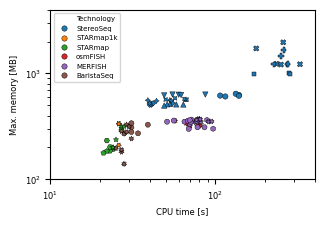

In [46]:
fig_runtime, ax = plt.subplots(figsize=(85 * mm, 60 * mm))

sns.scatterplot(
    data=runtime_stats.assign(
        Technology=lambda df: df["sample"].map(sample2technology)
    ),
    x="CPU time [s]",
    y="max memory [MB]",
    hue="Technology",
    style="sample",
    edgecolors="black",
    ax=ax,
    s=15,
)
_ = ax.set(
    xscale="log",
    yscale="log",
    xlim=(10, 400),
    ylim=(100, 4_000),
    ylabel="Max. memory [MB]",
)

h, l = ax.get_legend_handles_labels()
_ = ax.legend(h[:7], l[:7], loc="upper left")

fig_runtime.tight_layout()
fig_runtime.savefig(fig_dir / "Fig_Runtime.png", dpi=dpi)